In [ ]:
import os, yaml, sys

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import get_relevant_output_layers, compute_samples_sizes, load_img_natraster
from general_utils.static_dRSA import init_whole_neural_RDM, similarity_subsamples_par
from general_utils.plots import truncate_colormap

In [2]:
from dataclasses import dataclass, field

@dataclass
class Cfg:
    monkey_name: str = 'paul' 
    date: str = '230204'
    model_name: str = 'vit_l_16'
    img_size: int = 384
    brain_area: str = 'AIT'
    max_size: int = 300
    step_samples: int = 100 # of how many samples we jump every time
    similarity_measure: str = 'cosine'
    pooling: str = 'mean'
    new_fs: int = 100 # Hz
    n_iter: int = 3 # how many time we repeat the sampling
    RDM_metric: str = 'cosine'
    RSA_metric: str = 'correlation'
cfg = Cfg()

In [ ]:
task_list = get_relevant_output_layers(cfg.model_name)
area_rasters = load_img_natraster(paths, cfg)
n_trials = area_rasters.array.shape[2]
n_samples = compute_samples_sizes(cfg)
drsa_obj, whole_RDM_signal = init_whole_neural_RDM(area_rasters, cfg)
similarity_subsamples_par(paths, 0, "blocks.0.mlp.fc2", drsa_obj, whole_RDM_signal, n_samples, cfg)
#similarity_subsamples_par(rank: int, layer_name: str, drsa_obj: dRSA, n_samples: np.ndarray[int], cfg: Cfg)
# master_workers_queue(similarity_subsamples etc... 

16:25:49 - rank 0 computed the whole static dRSA for layer blocks.0.mlp.fc2
16:25:49 - rank 0 computed all iterations for layer blocks.0.mlp.fc2, 
saved at /Users/tizianocausin/livingstone_lab_local/tiziano/results/subsampling_100Hz_100-300_3iter_paul_230204_AIT_vit_l_16_384_blocks.0.mlp.fc2.npz


In [6]:
iter_dict = load_npz_as_dict("//Users/tizianocausin/livingstone_lab_local/tiziano/results/subsampling_100Hz_100-300_3iter_paul_230204_AIT_vit_l_16_384_blocks.0.mlp.fc2.npz")


In [5]:
import numpy as np

def load_npz_as_dict(path: str) -> dict[str, np.ndarray]:
    with np.load(path, allow_pickle=False) as data:
        return {k: data[k] for k in data.files}

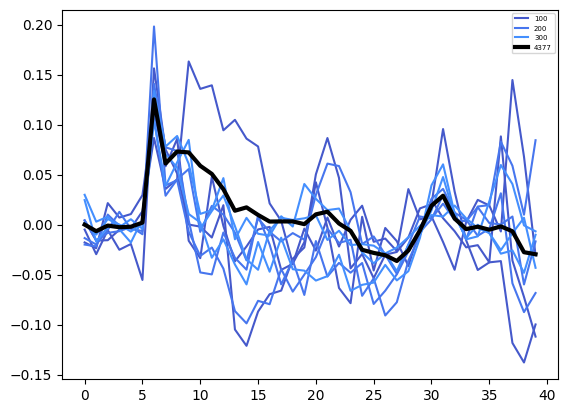

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
def truncate_colormap(cmap, minval=0.1, maxval=0.9, n=256):
    return LinearSegmentedColormap.from_list(
        f"trunc({cmap.name})",
        cmap(np.linspace(minval, maxval, n))
    )


base_cmap = plt.cm.turbo

cmap = truncate_colormap(base_cmap, 0.10, 0.90)
for idx, k in enumerate(n_samples[:30]):
    color = cmap(idx / (20 - 1))
    plt.plot(iter_dict[str(k)].T, color= color, label=k)
plt.plot(iter_dict[str(n_trials)], color="black", label=n_trials, linewidth=3)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=5)


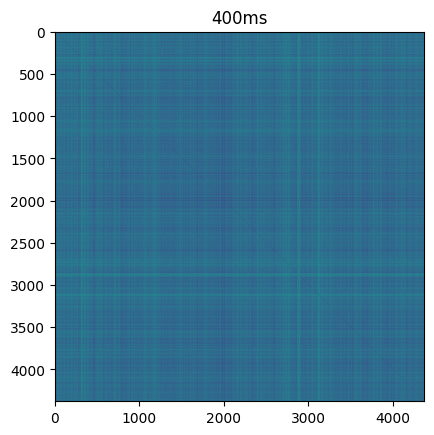

In [ ]:
# from IPython.display import clear_output

# for i_time, RDM_t in enumerate(whole_RDM_signal):
#     plt.imshow(RDM_t)
#     plt.title(f"{(i_time+1)*1000/cfg.new_fs:.0f}ms")
#     plt.pause(0.001)
#     plt.close() 
#     clear_output(wait=True)